# 3. Linear ODEs and Eigenvalue Problems

In [1]:
import numpy as np

from scipy.linalg import solve, eig

import matplotlib.pyplot as plt

In [2]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x  = np.cos(np.pi * row / N)
    c  = ((1 + (col % N == 0)) * (-1) ** col).T
    X  = np.ones(N + 1) * x
    dX = X - X.T
    D  = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

## 3.1. Simple Boundary Value Problem

Here we want to solve the linear boundary value problem

$$y''(x) + e^{4x} = 0\, , \quad y(-1) = y(1) = 0\, .$$

To do so, we build the discretized form of the equation using the differentiation matrix $D_2$, as

$$A \, y = b\, , \quad A = D_2\, , \quad b = - e^{4x}\, .$$

The boundary conditions are imposed by replacing the first and last rows of $A$ by the first and last rows of the identity matrix $I$, and the first and last elements of $b$ by 0. It turns out that this type of homogeneous Dirichlet conditions are equivalent to just removing the corresponding rows (and columns) altogether. This approach is intuitively more opaque, but reduces the size of the linear system to be solved.

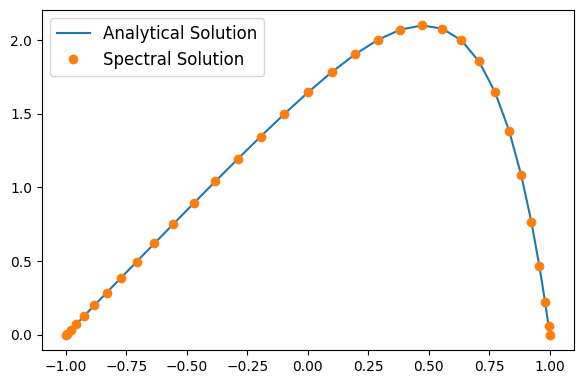

In [3]:
N = 32
x, D1, D2 = ChebyshevD(N)

L_bc = D2[1:-1, 1:-1]
x_bc = x[1:-1, :]
b_bc = - np.exp(4*x_bc)
y_bc = solve(L_bc, b_bc)

y    = np.vstack([0, y_bc , 0]) 

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(x, (np.cosh(4) + np.sinh(4) * x - np.exp(4 * x)) / 16, label = 'Analytical Solution')
ax.plot(x, y, 'o', label = 'Spectral Solution')
ax.legend(loc = 'upper left')

plt.tight_layout()
################################################################################

## 3.2. Simple Initial Value Problem

Now we turn to the harmonic oscillator equation

$$y''(x) + \pi^2 \, y(x) = 0\, , \quad y(-1) = \frac{1}{2}\, , \quad y'(-1) = \pi\, .$$

In this case, we define the discretized differential operator as $A = D_2 - \pi^2 \, I$. The boundary conditions are imposed by replacing the last row of $A$ by the last row of $I$, and the second-to-last row of $A$ by the last row of $D_1$. Then, the  inhomogeneous vector $b$ is filled by zeros except for its last two elements, which are $1/2$ and $\pi$, respectively. We then solve the linear system $A y = b$, as before.

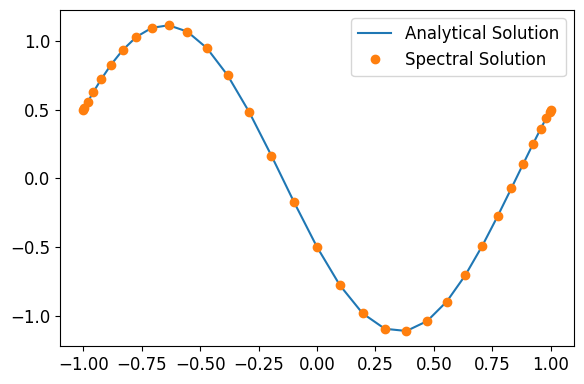

In [4]:
N = 32
x, D1, D2 = ChebyshevD(N)

I = np.eye(N+1)

L_bc = D2 + np.pi**2*I
L_bc[-1, :] = I[-1, :]
L_bc[-2, :] = D1[-1, :]

b_bc = 0.5 * I[:, -1] + np.pi * I[:, -2]

y  = solve(L_bc, b_bc)

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(x, - np.sin(np.pi * x) - 0.5 * np.cos(np.pi * x), label = 'Analytical Solution')
ax.plot(x, y, 'o', label = 'Spectral Solution')
ax.legend(loc = 'upper right')

plt.tight_layout()
################################################################################

## 3.3 Eigenvalue Problem with Dirichlet Boundary Conditions

In this case we want to solve the rescaled Bessel equation of order 0, which takes the form

$$x \, y'' + y' + \lambda^2 \, x \, y = 0\, , \quad y(1) = 0\, .$$

The solutions to this equation are $y_n(x) = J_0(\alpha_n  \, x)$, where $\alpha_n$ are the zeros of $J_0$. To do so, we will solve a generalized eigenvalue problem of the form $A \, y = \lambda^2 \, B \, y$, where we defined

$$A = \text{diag}(x) \cdot D_2 + D_1\, , \quad B = \text{diag}(x)\, .$$

Notice that multiplicative operators translate as just diagonal matrices in the discretized system of equations. The boundary condition is imposed by replacing the last row of $A$ (corresponding to $x = 1$) by the last row of the identity matrix, and the last row of $B$ by zero. This results in the equation $y_N = 0$. Regularity conditions at $x = 0$ are imposed automatically by spectral methods.

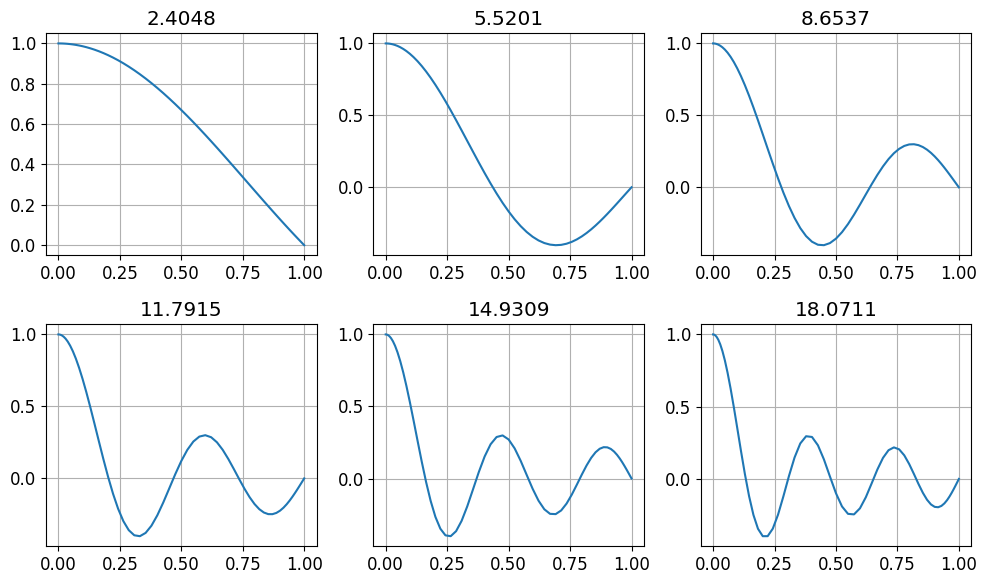

In [5]:
N = 64
x, D1, D2 = ChebyshevD(N)

x  = (1 - x) / 2
xf = x.flatten()
I = np.eye(N+1)
D1 = - 2 * D1
D2 = + 4 * D2 

A =   np.diag(xf) @ D2 + D1
B = - np.diag(xf)

A[-1,:] = I[-1,:]
B[-1,:] = 0

lam2, V = eig(A, B)

# Sort the eigenvalues and normalize
indices = np.argsort(lam2.real)
indices = indices[lam2[indices] > 0.001]
lam = np.sqrt(lam2.real[indices])
V   = V[:, indices]
V  /= (V[0, :] + (V[0, :]==0))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(2,3, figsize = (10, 6));
plt.rc('font', size = 12)

for i in range(2):
    for j in range(3):
        ax[i, j].plot(x, V[:, 3*i + j])
        ax[i, j].set_title(f'{lam[3*i + j]:.4f}')
        ax[i, j].grid()

plt.tight_layout()
################################################################################

## 3.4 Eigenvalue Problem with Neumann Boundary Conditions

We can also impose Neumann boundary conditions, of the form

$$x \, y'' + y' + \lambda^2 \, x \, y = 0\, , \quad y'(1) = 0\, .$$

The analytical solution in this case is  $y_n(x) = J_0(\beta_n  \, x)$, where $\beta_n$ are the extrema of $J_0$. The spectral procedure is almost identical to the one in the previous example, but in this case we replace the last row of $A$ by the last row of $D_1$.

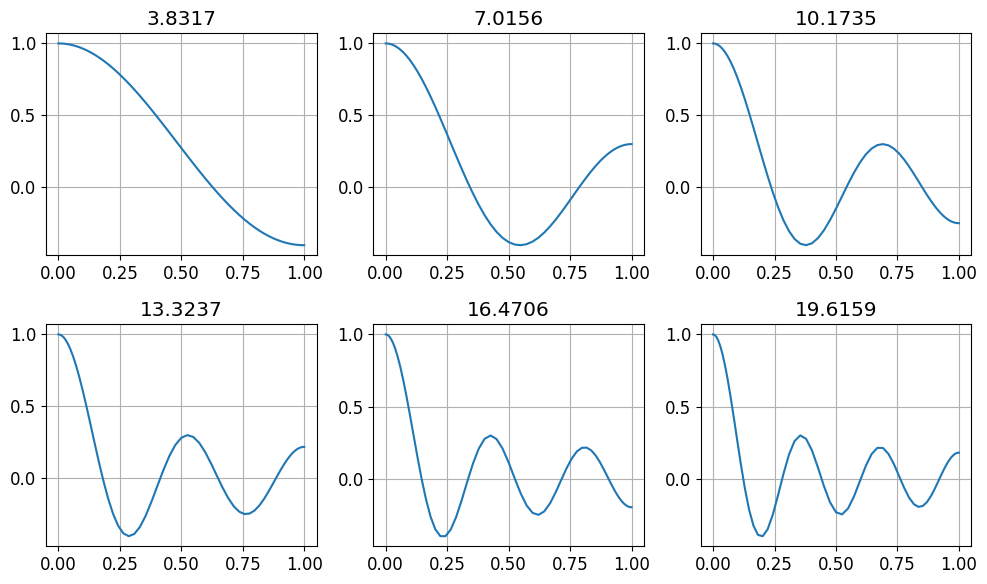

In [6]:
N = 64
x, D1, D2 = ChebyshevD(N)

x  = (1 - x) / 2
xf = x.flatten()
D1 = - 2 * D1
D2 = + 4 * D2 

A =   np.diag(xf) @ D2 + D1
B = - np.diag(xf)

A[-1,:] = D1[-1,:]
B[-1,:] = 0

lam2, V = eig(A, B)

# Sort the eigenvalues and normalize
indices = np.argsort(lam2.real)
indices = indices[lam2[indices] > 0.001]
lam = np.sqrt(lam2.real[indices])
V   = V[:, indices]
V  /= (V[0, :] + (V[0, :]==0))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(2,3, figsize = (10, 6));
plt.rc('font', size = 12)

for i in range(2):
    for j in range(3):
        ax[i, j].plot(x, V[:, 3*i + j])
        ax[i, j].set_title(f'{lam[3*i + j]:.4f}')
        ax[i, j].grid()

plt.tight_layout()
################################################################################

## 3.5 Quantum Anharmonic Oscillator

Let's now calculate the ground state energy of a quantum anharmonic oscillator with a quartic Haniltonian, of the form

$$ \hat H = - \frac{\hbar^2}{2m}\partial_x^2 + \frac{m w^2}{2} x^2 + g \frac{m^2 w^3}{\hbar} x^4\, .$$

The perturbative series in powers of the coupling constant $g$ was computed by Bender and Wu in

> [**Anharmonic oscillator**](https://doi.org/10.1103/PhysRev.184.1231)   
> Carl M. Bender and Tai Tsun Wu
> <br>**Phys.Rev. 184 (1969) 1231-1260**<br>
> https://doi.org/10.1103/PhysRev.184.1231<br>

Let's compare now this (asymptotic) series to the numerical results for a range of the coupling $g$.

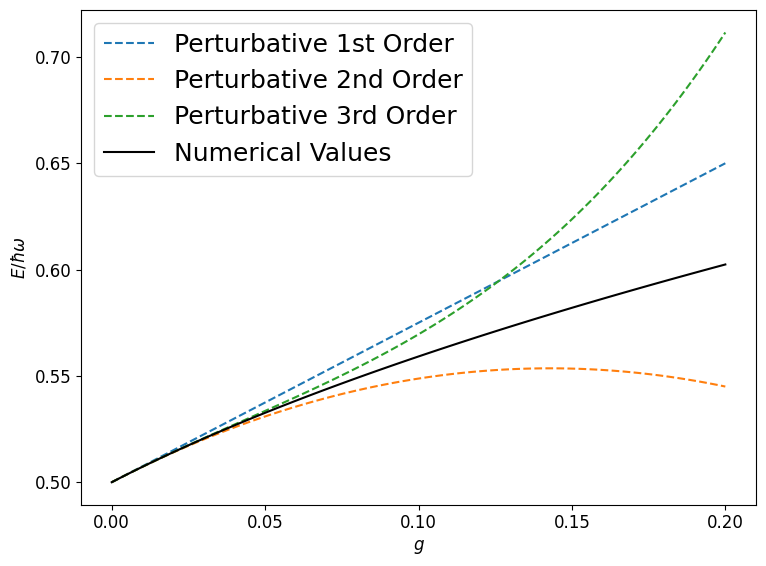

In [7]:
# Parameters of the computation
N        = 128
g_values = np.linspace(0., .2, 100)

# Prepare the spectral grids
x, D1, D2 = ChebyshevD(N)
x  = - 5 * x
xf = x.flatten()
I  = np.eye(N+1)
D2 = + D2 / 25

def numerical_energy(g):
    A = - 0.5 * D2 + 0.5 * np.diag(xf**2) + g * np.diag(xf**4)
    B = I.copy()
    
    A[0,:]  = I[0, :]
    A[-1,:] = I[-1,:]
    B[0,:]  = B[-1,:] = 0
    
    E, V = eig(A, B)
    return np.min(E.real)

def perturbative_energy(g, order):
    coefs = [+1/2, +3/4, -21/8, +333/16, -30885/128, +916731/256, -65518401/1024, 
             +2723294673/2048, -1030495099053/32768, +54626982511455/65536]
    E = 0
    for k in range(order + 1):
        E += coefs[k] * g**k
    return E

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(figsize = (8, 6))
plt.rc('font', size = 18)

ax.plot(g_values, [perturbative_energy(g, 1) for g in g_values], '--', label = 'Perturbative 1st Order')
ax.plot(g_values, [perturbative_energy(g, 2) for g in g_values], '--', label = 'Perturbative 2nd Order')
ax.plot(g_values, [perturbative_energy(g, 3) for g in g_values], '--', label = 'Perturbative 3rd Order')
ax.plot(g_values, [numerical_energy(g) for g in g_values], 'k',  label = 'Numerical Values')
ax.set_xlabel('$g$')
ax.set_ylabel('$E / \\hbar \\omega$')
ax.legend()

plt.tight_layout()
################################################################################